In [41]:
import pandas as pd
import numpy as np

df = pd.read_csv('BusinessMasterFile.csv')
df.head()

,EIN,NAME,ICO,STREET,CITY,STATE,ZIP,GROUP,SUBSECTION,AFFILIATION,...,ASSET_AMT,INCOME_AMT,REVENUE_AMT,NTEE_CD,SORT_NAME,RULEYEAR,LEVEL4,ACT1,ACT2,ACT3
0,19818,PALMER SECOND BAPTIST CHURCH,NaN,1050 THORNDIKE ST,PALMER,MA,01069-1507,3125,3,9,...,NaN,NaN,NaN,NaN,3514,1955,NaN,100,0.0,0.0
1,29215,ST GEORGE CATHEDRAL,NaN,523 E BROADWAY,SOUTH BOSTON,MA,02127-4415,2365,3,9,...,NaN,NaN,NaN,NaN,NaN,1972,NaN,100,0.0,0.0
2,587764,IGLESIA BETHESDA INC,NaN,157 ANDOVER ST,LOWELL,MA,01852-2348,0,3,3,...,NaN,NaN,NaN,X21,NaN,2004,X,0,NaN,NaN
3,635913,MINISTERIO APOSTOLICO JESUCRISTO ES EL SENOR INC,NaN,454 ESSEX ST,LAWRENCE,MA,01840-1242,0,3,3,...,NaN,NaN,NaN,X21,NaN,2004,X,0,NaN,NaN
4,765634,MERCY CHAPEL INTERNATIONAL,NaN,75 MORTON VILLAGE DR APT 408,MATTAPAN,MA,02126-2433,0,3,3,...,NaN,NaN,NaN,X20,NaN,2004,X,0,NaN,NaN


In [42]:
import missingno as msno
import matplotlib.pyplot as plt
plt.style.use('ggplot')

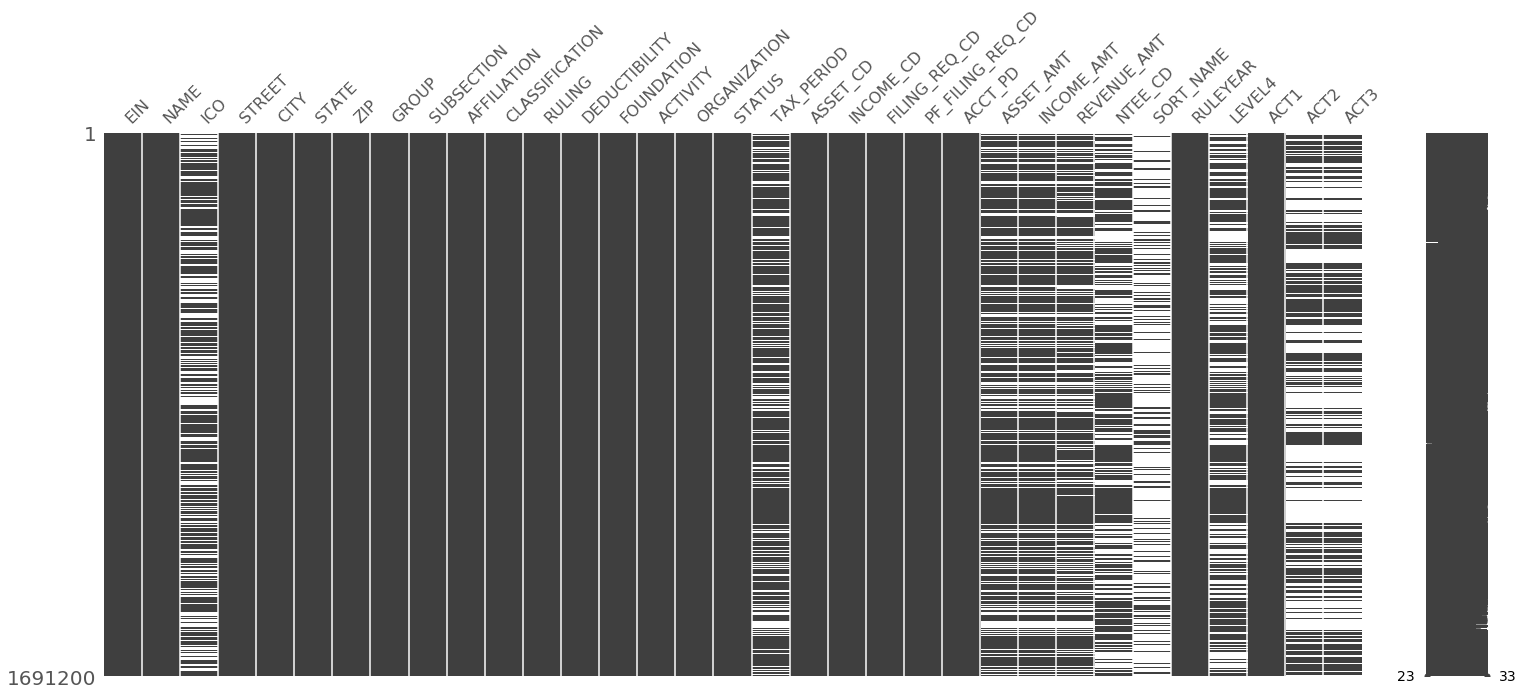

In [43]:
msno.matrix(df)

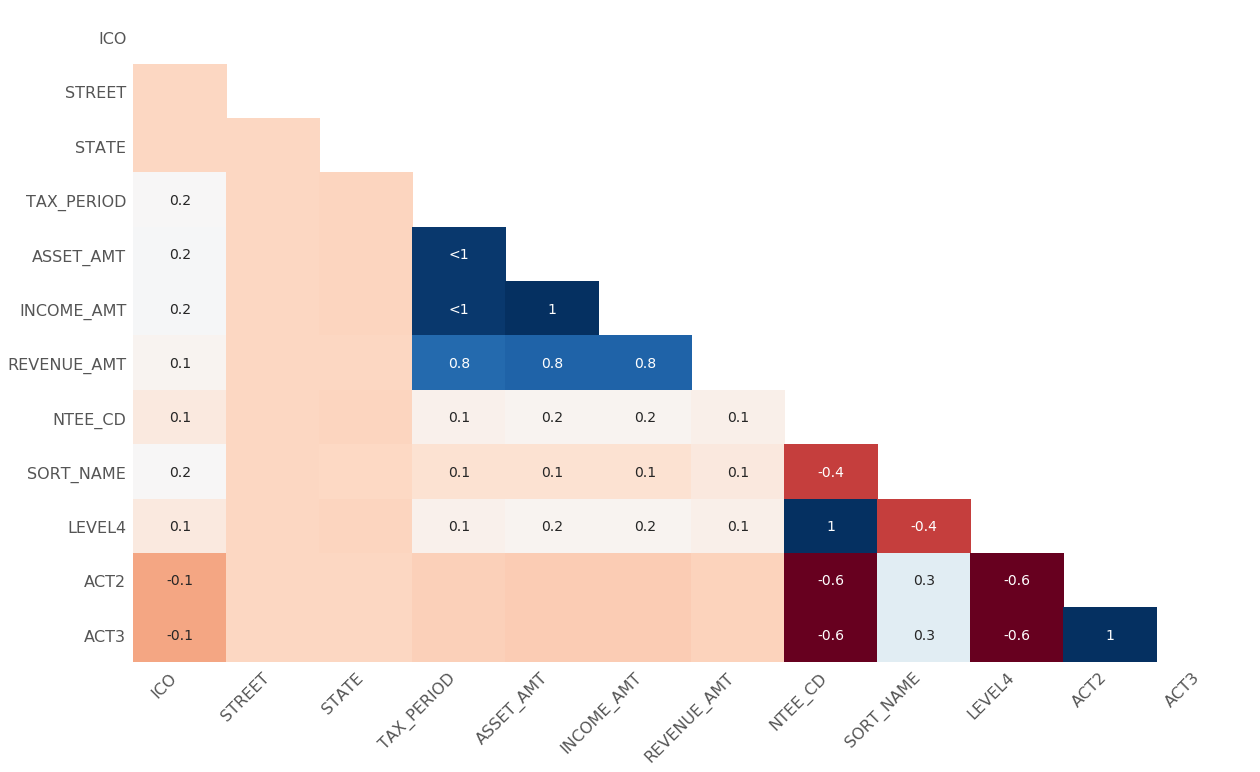

In [4]:
msno.heatmap(df)

In [54]:
df.ICO.value_counts()

% PEO TREASURER                       5793
% TREASURER                           4615
% CRAIG MILLER                        1568
% CHIEF FINANCIAL OFFICER             1527
% PRESIDENT                           1472
% FOUNDATION SOURCE                   1296
% DOUG MILLS                          1283
%                                     1229
% EXECUTIVE DIRECTOR                  1223
% PASTOR                              1174
% FINANCIAL SECRETARY                  921
% NA                                   910
% 4-H PROGRAM COORDINATOR              811
% TAX DEPT                             780
% KENNETH W RAY                        766
% PNC BANK NA                          744
% ELLEN M LINTAL                       659
% BANK OF AMERICA NA                   616
% JPMORGAN CHASE BANK NA               578
% TERRY NOVY                           544
% PTA OFFICER                          537
% BETA BETA BETA BIOLOGY HONOR SOC     529
% PTA PRESIDENT                        519
% WEAC     

,EIN,NAME,ICO,STREET,CITY,STATE,ZIP,GROUP,SUBSECTION,AFFILIATION,...,ASSET_AMT,INCOME_AMT,REVENUE_AMT,NTEE_CD,SORT_NAME,RULEYEAR,LEVEL4,ACT1,ACT2,ACT3
248230,10553362,NATIONAL WILD TURKEY FEDERATION INC,% CRAIG MILLER,770 AUGUSTA RD,EDGEFIELD,SC,29824-1573,8632,3,9,...,NaN,NaN,NaN,NaN,HIGHLAND LAKES CHAPTER TX,1993,NaN,350,0.0,0.0
248442,10596844,NATIONAL WILD TURKEY FEDERATION INC,% CRAIG MILLER,770 AUGUSTA RD,EDGEFIELD,SC,29824-1573,8632,3,9,...,NaN,NaN,NaN,NaN,KANSAS STATE CHAPTER,1993,NaN,0,NaN,NaN
248444,10596895,NATIONAL WILD TURKEY FEDERATION INC,% CRAIG MILLER,770 AUGUSTA RD,EDGEFIELD,SC,29824-1573,8632,3,9,...,NaN,NaN,NaN,NaN,OAK TREE GOBBLERS WI,1993,NaN,350,0.0,0.0
248445,10596915,NATIONAL WILD TURKEY FEDERATION INC,% CRAIG MILLER,770 AUGUSTA RD,EDGEFIELD,SC,29824-1573,8632,3,9,...,NaN,NaN,NaN,NaN,FLOYD COUNTY TURKEY TRACKERS IA,1993,NaN,350,0.0,0.0
248449,10596980,NATIONAL WILD TURKEY FEDERATION INC,% CRAIG MILLER,770 AUGUSTA RD,EDGEFIELD,SC,29824-1573,8632,3,9,...,NaN,NaN,NaN,NaN,RIVER CITY GOBBLERS GA,1993,NaN,350,0.0,0.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1691200 entries, 0 to 1691199
Data columns (total 33 columns):
EIN                 int64
NAME                object
ICO                 object
STREET              object
CITY                object
STATE               object
ZIP                 object
GROUP               int64
SUBSECTION          int64
AFFILIATION         int64
CLASSIFICATION      int64
RULING              int64
DEDUCTIBILITY       int64
FOUNDATION          int64
ACTIVITY            int64
ORGANIZATION        int64
STATUS              int64
TAX_PERIOD          float64
ASSET_CD            int64
INCOME_CD           int64
FILING_REQ_CD       int64
PF_FILING_REQ_CD    int64
ACCT_PD             int64
ASSET_AMT           float64
INCOME_AMT          float64
REVENUE_AMT         float64
NTEE_CD             object
SORT_NAME           object
RULEYEAR            int64
LEVEL4              object
ACT1                int64
ACT2                float64
ACT3                float64
dtypes: 

In [7]:
print(df.REVENUE_AMT.value_counts()[:5])
df.REVENUE_AMT.isna().value_counts()

0.0        688791
1000.0        296
500.0         221
5000.0        215
100.0         214
1.0           204
10000.0       185
2000.0        163
3000.0        133
200.0         129
1500.0        122
2500.0        116
2.0           105
6000.0        103
300.0          99
5.0            98
Name: REVENUE_AMT, dtype: int64


False    1212088
True      479112
Name: REVENUE_AMT, dtype: int64

In [8]:
print(df.ASSET_AMT.value_counts()[:5])
print(df.ASSET_AMT.isna().sum())
print(df.ASSET_CD.value_counts()[:5])
print(df.ASSET_CD.isna().sum())

0.0        677902
1.0         15623
100.0         285
1000.0        217
500.0         191
200.0         120
2000.0        108
5000.0        103
10.0          101
50.0           90
300.0          83
1500.0         81
150.0          73
10000.0        69
25.0           69
5.0            67
Name: ASSET_AMT, dtype: int64
368826
0    1032113
4     169004
3     123873
6     101784
1      80491
Name: ASSET_CD, dtype: int64
0


I am trying to decide whether or not to drop ASSEST_CD/ASSET_AMT and INCOME_AMT/INCOME_CD.

ASSET_AMT is continious data, rather than the coded data in ASSET_CD, so I will keep the AMTs reported over the prebinned. I can alter it myself if need be. Also there seems to be some discrepancy in values from the coded and the reported, which makes my decision. 

Tasks:
- Combine `city`, `street`, `state` into lat and longs. Drop `city`, `street`, `state`. This is the location of the headquarters and doesn't mean that the 501c has operations in that state. [https://github.com/geopy/geopy]
- Change datetime data into correct formats. `TAX_PERIOD`, `RULING_DATE`
- Make things categorical
- Investigate any connection between SORT_NAME and GROUP EXEMPTION NUM and AFFILCATION CODE [Connection?](#task1)
- Check the Ruling year after 1995 and see if any NTEE exisits.


<a id="task1"></a>

Sort Name Line is another name under which the organization does business.  Also used for trade names, chapter names, or local numbers for subordinate organizations of group rulings

Central - This code is used if the organization is a central type organization (no group exemption) of a National, Regional or Geographic grouping of organizations. 2 Intermediate - This code is used if the organization is an intermediate organization (no group exemption) of a National, Regional or Geographic grouping of organizations (such as a state headquarters of a national organization). 3 Independent - This code is used if the organization is an independent organization or an independent auxiliary 
(i.e., not affiliated with a National, Regional, or Geographic grouping of organizations). 6 Central - This code is used if the organization is a parent (group ruling) and is not a church or 501(c)(1) organization. 7 Intermediate - This code is used if the organization is a group exemption intermediate organization of a National, Regional or Geographic grouping of organizations. 8 Central - This code is used if the organization is a parent (group ruling) and is a church or 501(c)(1) organization. 9 Subordinate - This code is used if the organization is a subordinate in a group ruling

In [9]:
df.drop(['ICO', 
         'RULING', 
         'ACT2', 
         'ACT3', 
         'ASSET_CD', 
         'INCOME_CD', 
         'LEVEL4', 
         'TAX_PERIOD'], axis=1, inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1691200 entries, 0 to 1691199
Data columns (total 25 columns):
EIN                 int64
NAME                object
STREET              object
CITY                object
STATE               object
ZIP                 object
GROUP               int64
SUBSECTION          int64
AFFILIATION         int64
CLASSIFICATION      int64
DEDUCTIBILITY       int64
FOUNDATION          int64
ACTIVITY            int64
ORGANIZATION        int64
STATUS              int64
FILING_REQ_CD       int64
PF_FILING_REQ_CD    int64
ACCT_PD             int64
ASSET_AMT           float64
INCOME_AMT          float64
REVENUE_AMT         float64
NTEE_CD             object
SORT_NAME           object
RULEYEAR            int64
ACT1                int64
dtypes: float64(3), int64(15), object(7)
memory usage: 322.6+ MB


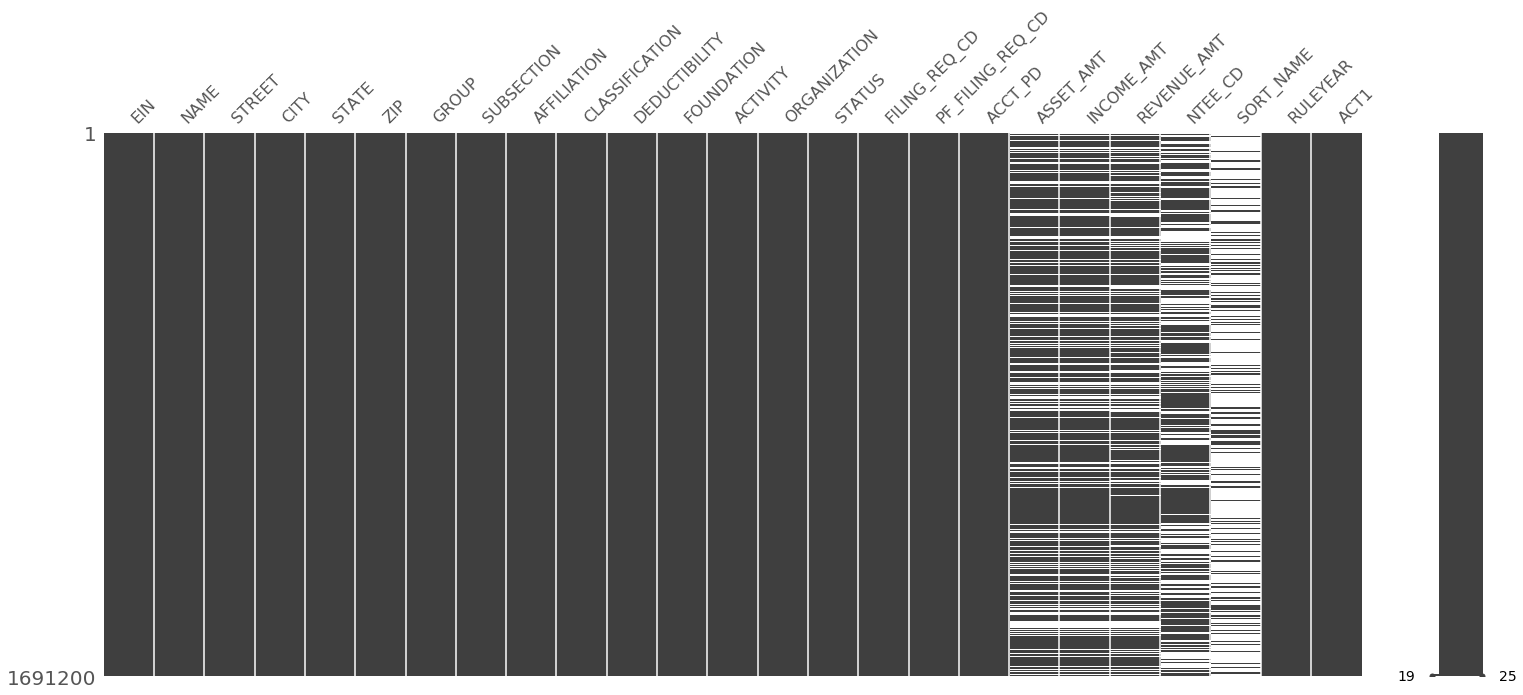

In [11]:
msno.matrix(df)

There is a clear pattern of missing values from `ASSET_AMT`,`INCOME_AMT`, and `REVENUE_AMT`. I will drop values from one column, extending down the rows and then will recheck the patterns.

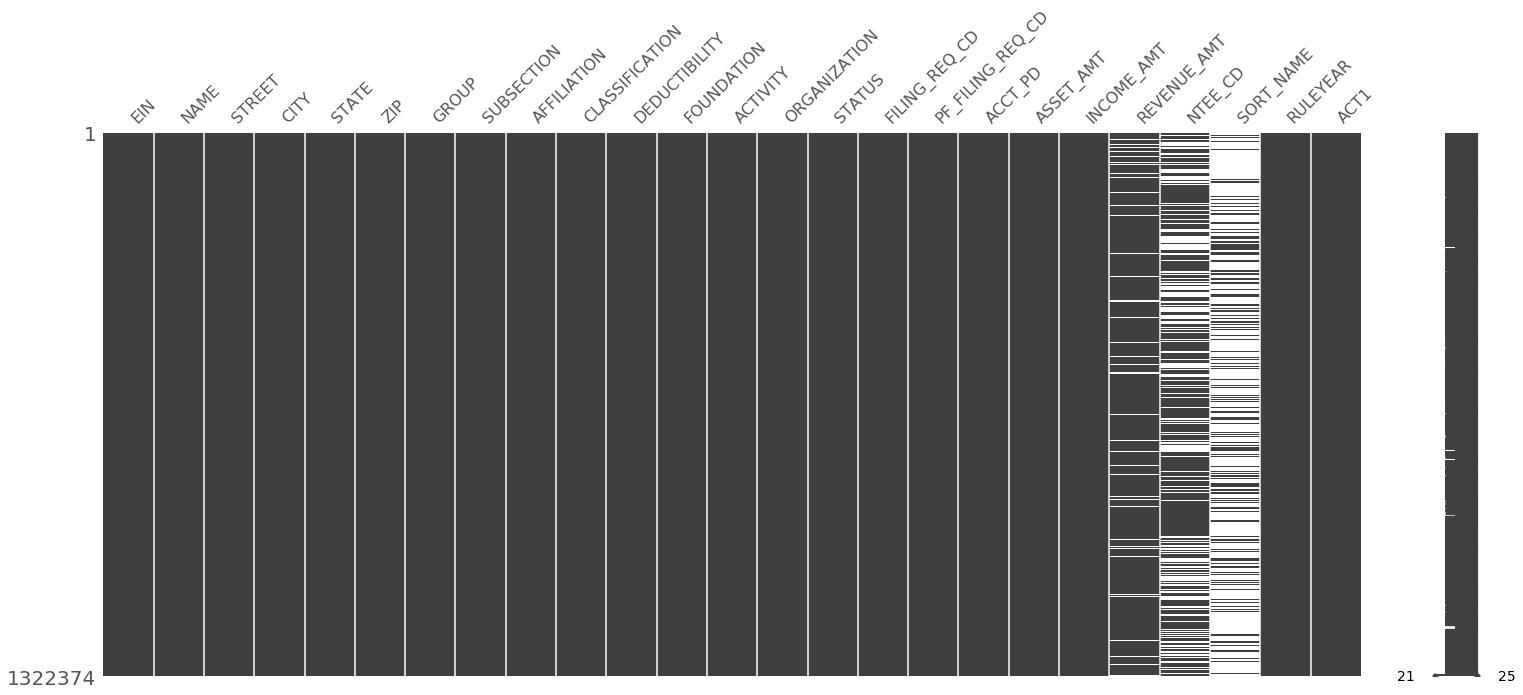

In [12]:
df = df.dropna(subset=['ASSET_AMT'])
msno.matrix(df)

~370,000 entries were removed. 

In [13]:
df.isna().sum()

EIN                      0
NAME                     0
STREET                   2
CITY                     0
STATE                 1062
ZIP                      0
GROUP                    0
SUBSECTION               0
AFFILIATION              0
CLASSIFICATION           0
DEDUCTIBILITY            0
FOUNDATION               0
ACTIVITY                 0
ORGANIZATION             0
STATUS                   0
FILING_REQ_CD            0
PF_FILING_REQ_CD         0
ACCT_PD                  0
ASSET_AMT                0
INCOME_AMT               0
REVENUE_AMT         110286
NTEE_CD             451552
SORT_NAME           965875
RULEYEAR                 0
ACT1                     0
dtype: int64

The last 100K from `REVENUE_AMT` will be dropped as well. I will combine the `SORT_NAME` column with the `NAME` column since they both come from the same field, just a different line. `NTEE_CD` will be addressed seperately as well.

In [14]:
df = df.dropna(subset=['REVENUE_AMT'])

In [15]:
df.isna().sum()

EIN                      0
NAME                     0
STREET                   2
CITY                     0
STATE                  940
ZIP                      0
GROUP                    0
SUBSECTION               0
AFFILIATION              0
CLASSIFICATION           0
DEDUCTIBILITY            0
FOUNDATION               0
ACTIVITY                 0
ORGANIZATION             0
STATUS                   0
FILING_REQ_CD            0
PF_FILING_REQ_CD         0
ACCT_PD                  0
ASSET_AMT                0
INCOME_AMT               0
REVENUE_AMT              0
NTEE_CD             415581
SORT_NAME           868547
RULEYEAR                 0
ACT1                     0
dtype: int64

In [16]:
df.SORT_NAME = df.SORT_NAME.fillna(value = '') #Replaces np.NaN values with something else, string + np.NaN = np.NaN
df['NAME_FULL'] = df.NAME + ' ' + df.SORT_NAME #New column
df.drop(['NAME', 'SORT_NAME'], axis=1, inplace=True) #Getting rid of the old
df.head()

,EIN,STREET,CITY,STATE,ZIP,GROUP,SUBSECTION,AFFILIATION,CLASSIFICATION,DEDUCTIBILITY,...,FILING_REQ_CD,PF_FILING_REQ_CD,ACCT_PD,ASSET_AMT,INCOME_AMT,REVENUE_AMT,NTEE_CD,RULEYEAR,ACT1,NAME_FULL
12,10002847,PO BOX 126,HULLS COVE,ME,04644-0126,0,3,3,1000,1,...,2,0,12,0.0,0.0,0.0,A80,2000,0,HULLS COVE NEIGHBORHOOD ASSOCIATION
13,10011694,30 SAMUEL PRESCOTT DR,STOW,MA,01775-1167,0,3,3,1000,1,...,2,0,12,0.0,0.0,0.0,S19,2015,995,MASSACHUSETTS MODERATORS ASSOCIATION
14,10015091,PO BOX 13,CEDAR KNOLLS,NJ,07927-0013,0,3,3,1000,1,...,1,0,12,62462.0,140685.0,140685.0,N64,2012,0,HANOVER SOCCER CLUB INC
15,10017496,PO BOX 534,YORK HARBOR,ME,03911-0534,0,3,3,2000,1,...,1,0,12,233819.0,180773.0,127013.0,NaN,1993,149,AGAMENTICUS YACHT CLUB OF YORK
16,10018555,81 COLLEGE AVE,ORONO,ME,04473-4210,287,7,9,1000,2,...,2,0,12,0.0,0.0,0.0,NaN,1941,360,ALPHA TAU OMEGA FRATERNITY BETA UPSILION MAINE...


In [17]:
df.isna().sum()

EIN                      0
STREET                   2
CITY                     0
STATE                  940
ZIP                      0
GROUP                    0
SUBSECTION               0
AFFILIATION              0
CLASSIFICATION           0
DEDUCTIBILITY            0
FOUNDATION               0
ACTIVITY                 0
ORGANIZATION             0
STATUS                   0
FILING_REQ_CD            0
PF_FILING_REQ_CD         0
ACCT_PD                  0
ASSET_AMT                0
INCOME_AMT               0
REVENUE_AMT              0
NTEE_CD             415581
RULEYEAR                 0
ACT1                     0
NAME_FULL                0
dtype: int64

My target is going to `ACTIVITY`. The values in this are 9 charaters long, each set of three indicating what kind of the organization it is. There are some that needed more than one set of three to define their organization, others only have one. Planning to use only the first activity code. Multiple targets would not be ideal. Also I have to keep in mind, there are ones that could apply to different targets.

In [22]:
df.loc[(df.NTEE_CD.notna()) & (df.ACTIVITY == 0)].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 604936 entries, 12 to 1691194
Data columns (total 24 columns):
EIN                 604936 non-null int64
STREET              604936 non-null object
CITY                604936 non-null object
STATE               604403 non-null object
ZIP                 604936 non-null object
GROUP               604936 non-null int64
SUBSECTION          604936 non-null int64
AFFILIATION         604936 non-null int64
CLASSIFICATION      604936 non-null int64
DEDUCTIBILITY       604936 non-null int64
FOUNDATION          604936 non-null int64
ACTIVITY            604936 non-null int64
ORGANIZATION        604936 non-null int64
STATUS              604936 non-null int64
FILING_REQ_CD       604936 non-null int64
PF_FILING_REQ_CD    604936 non-null int64
ACCT_PD             604936 non-null int64
ASSET_AMT           604936 non-null float64
INCOME_AMT          604936 non-null float64
REVENUE_AMT         604936 non-null float64
NTEE_CD             604936 non-null o

In [19]:
df.NTEE_CD.notna().sum()

796507

In [20]:
df.NTEE_CD.isna().sum()

415581

In [36]:
df.ACTIVITY.value_counts()

0            648115
59000000      12946
907908000     11636
59035000      11596
205000000     10981
36000000      10129
263264279      9497
200000000      9436
319000000      8836
59319000       8748
36029265       8118
602000000      7925
263000000      6872
35000000       6562
998000000      5401
999000000      5397
320000000      5388
907000000      5290
520349200      4829
123000000      4716
149349000      4684
59921319       4303
900000000      4143
260000000      4098
279000000      3969
407000000      3925
119000000      3867
40000000       3648
29000000       3478
160000000      3041
              ...  
904922201         1
259904995         1
430059036         1
602093119         1
407179000         1
7008004           1
179382399         1
902561575         1
298059480         1
160119600         1
36034285          1
380566408         1
200149910         1
995040180         1
296575995         1
160531559         1
915537000         1
408603918         1
402429381         1


Tester set for a encoding that I will do.

In [24]:
small = df.loc[(df.NTEE_CD.notna()) & (df.ACTIVITY == 0)][:100]

In [40]:
df['NAME_FULL'].loc[df.ACTIVITY == 907908000]

19             AMERICAN LEGION POST 0019 THOMAS W COLE POST 
20                AMERICAN LEGION POST 0005 BOURQUE LANIGAN 
21                          AMERICAN LEGION 22 DEPT OF MAINE
102               AMERICAN LEGION 24 NAPOLEON OUELLETTE POST
147        DEPARTMENT OF MAINE VETERANS OF FOREIGN WARS O...
148                AMERICAN LEGION 0002 FITZGERALD-CUMMINGS 
152        VETERANS OF FOREIGN WARS OF THE UNITED STATES ...
159        VETERANS OF FOREIGN WARS OF THE UNITED STATES ...
164                    AMERICAN LEGION POST 0147 THOS O CYR 
166        VETERANS OF FOREIGN WARS OF THE UNITED STATES ...
167                                  AMERICAN LEGION 40 POST
170                AMERICAN LEGION 49 LEVASSEUR FARRELL POST
171        AMERICAN LEGION 0001 POST WINSLOW HOLBROOK MER...
184                  AMERICAN LEGION GROVER HINCKLEY POST 14
187                 AMERICAN LEGION POST 0015 HENRY B PRATT 
260              AMERICAN LEGION POST 0158 COOMBS MOUNTFORT 
275             AMERICAN

In [27]:
def code_NTEE(x):
list_a
list_b
list_c
list_d
    if x in :
        return 'A'
    if x in :
        return 'B'
    if x in :
        return 'C'
    if x in :
        return 'D'
    if x in :
        return 'E'
    if x in :
        return 'F'
    if x in :
        return 'G'
    if x in :
        return 'H'
    if x in :
        return 'I'
    if x in :
        return 'J'
    if x in :
        return 'K'
    if x in :
        return 'L' 
    if x in :
        return 'M'
    if x in :
        return 'N'
    if x in :
        return 'O'
    if x in :
        return 'P'
    if x in :
        return 'Q'
    if x in :
        return 'R'
    if x in :
        return 'S'
    if x in :
        return 'T'
    if x in :
        return 'U'
    if x in :
        return 'V'
    if x in :
        return 'W'
    if x in :
        return 'X'
    if x in :
        return 'Y'
    if x in :
        return 'Z'
    else:
        print(f'Check this code out {x}')

IndentationError: expected an indented block (<ipython-input-27-ead787f84365>, line 2)